In [1]:
# Librerie principali
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch & torchvision
import torch
from torchvision import models
from torchvision.models import ResNet50_Weights

# OpenCV
import cv2

# Similarità
from sklearn.metrics.pairwise import cosine_distances

Setup

In [7]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()

# Carica features da file .npz
data = np.load("resnetfc.npz", allow_pickle=True)
feature_matrix = data["features"]
filenames = data["filenames"]
labels = data["labels"]



Funzione Estrazione Feature - Task 1-2

In [15]:
def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Estrae le feature del layer fully connected (fc) di ResNet50 da un'immagine.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"[ERRORE] Immagine non valida {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    fc_output = []

    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    if fc_output:
        return fc_output[0].squeeze(0).cpu().numpy()
    else:
        print(f"[ERRORE] Nessun output FC per {image_path}")
        return None

Elaborazione Batch e Salvataggio Feature in .npz

In [4]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_fc_features_from_image(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

 Retrieval: Immagini più Simili (distanza coseno) - Task 3

In [5]:
def find_k_similar_cosine(img_path, k):
    """
    Trova le k immagini più simili rispetto a una query, usando la distanza coseno.
    """
    query_feature = extract_fc_features_from_image(img_path, model, preprocess, device)
    if query_feature is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = cosine_distances(feature_matrix, query_feature).flatten()

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# Parametri cartelle e output
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
output_file = "resnetfc.npz"

# Estrazione e salvataggio
process_and_save_features(base_folder, subfolders, output_file)

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnetfc.npz
[FINE] Totale immagini processate: 3006



Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg
1. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.0000
2. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0604
3. brain_glioma_0633.jpg | Classe: brain_glioma | Distanza: 0.0684
4. brain_glioma_0312.jpg | Classe: brain_glioma | Distanza: 0.0717
5. brain_glioma_0437.jpg | Classe: brain_glioma | Distanza: 0.0719


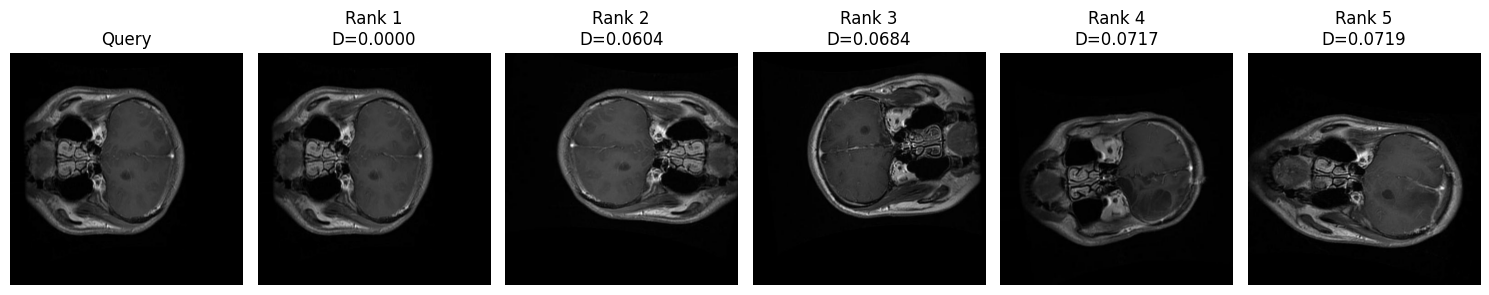

In [8]:

# Test su immagine di query
query_img = "Part1/brain_glioma/brain_glioma_0017.jpg"
find_k_similar_cosine(query_img, k=5)

Task 4:

In [24]:
import numpy as np
import os

def task4_predict_labels_resnetfc(query_img_path, k, extractor_fn, features, labels, metric="euclidean"):
    """
    Predict top-k labels for query image using ResNet FC features.
    extractor_fn: funzione che prende image_path e restituisce feature numpy array
    features: matrice numpy (N, d)
    labels: array di stringhe (N,)
    metric: "euclidean" o "cosine"
    """
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")

    def compute_metric(query_feat, target_feats, metric):
        query_feat = query_feat.reshape(1, -1)
        if metric == "euclidean":
            # distanza euclidea tra query_feat e tutti target_feats
            return np.linalg.norm(target_feats - query_feat, axis=1)
        elif metric == "cosine":
            # similarità coseno tra query_feat e tutti target_feats
            # sim = (A·B) / (|A||B|), distanza = 1 - sim
            dot_prod = np.dot(target_feats, query_feat.T).flatten()
            norm_feats = np.linalg.norm(target_feats, axis=1)
            norm_query = np.linalg.norm(query_feat)
            cosine_sim = dot_prod / (norm_feats * norm_query + 1e-10)
            cosine_dist = 1 - cosine_sim  # distanza coseno
            return cosine_dist
        else:
            raise ValueError("Metric must be 'euclidean' or 'cosine'")

    def predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        scores = []
        for label in unique_labels:
            class_feats = features[labels == label]
            dists = compute_metric(query_feat, class_feats, metric)
            scores.append(dists.mean())
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:  # cosine distanza: più piccola è meglio
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

    def predict_top_k_labels_prototype(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        prototypes = []
        for label in unique_labels:
            class_feats = features[labels == label]
            prototypes.append(class_feats.mean(axis=0))
        prototypes = np.vstack(prototypes)
        scores = compute_metric(query_feat, prototypes, metric)
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

    predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric)
    predict_top_k_labels_prototype(query_img_path, k, features, labels, metric)


In [26]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feature_matrix,
    labels=labels,
    metric="euclidean"
)

task4_predict_labels_resnetfc(
    query_img, k=2,
    extractor_fn=lambda img: extract_fc_features_from_image(img, model, preprocess, device),
    features=feature_matrix,
    labels=labels,
    metric="cosine"
)



======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: euclidean]
Classe: brain_tumor | Score medio: 41.4859
Classe: brain_menin | Score medio: 44.3253

[STRATEGIA: prototipo di classe - metrica: euclidean]
Classe: brain_menin | Score: 28.2170
Classe: brain_tumor | Score: 28.2899

======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: cosine]
Classe: brain_tumor | Score medio: 0.1648
Classe: brain_menin | Score medio: 0.2079

[STRATEGIA: prototipo di classe - metrica: cosine]
Classe: brain_tumor | Score: 0.0877
Classe: brain_menin | Score: 0.0958


Task 5:

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def task5_latent_semantics_resnetfc(feature_model_path, technique, k):
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa
            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


def plot_latent_space_2d(X_transformed, labels, technique, k):
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


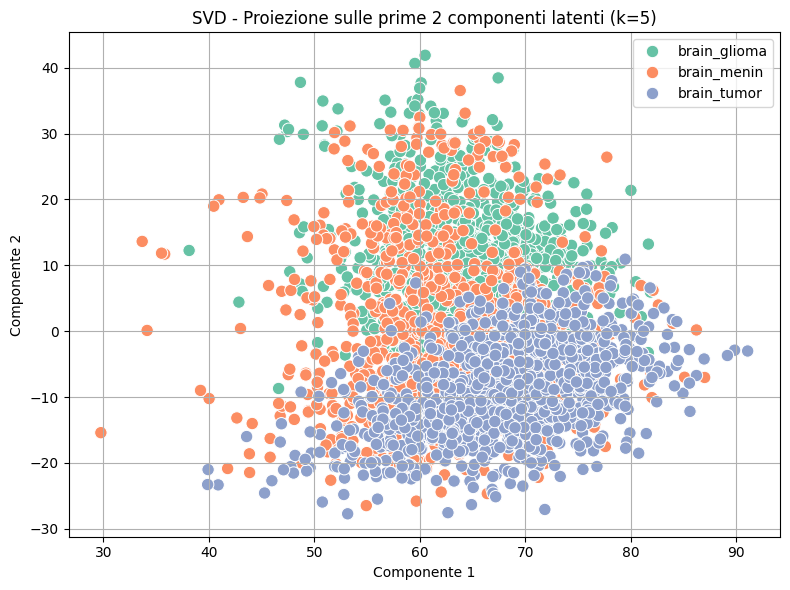

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnetfc_k5.txt


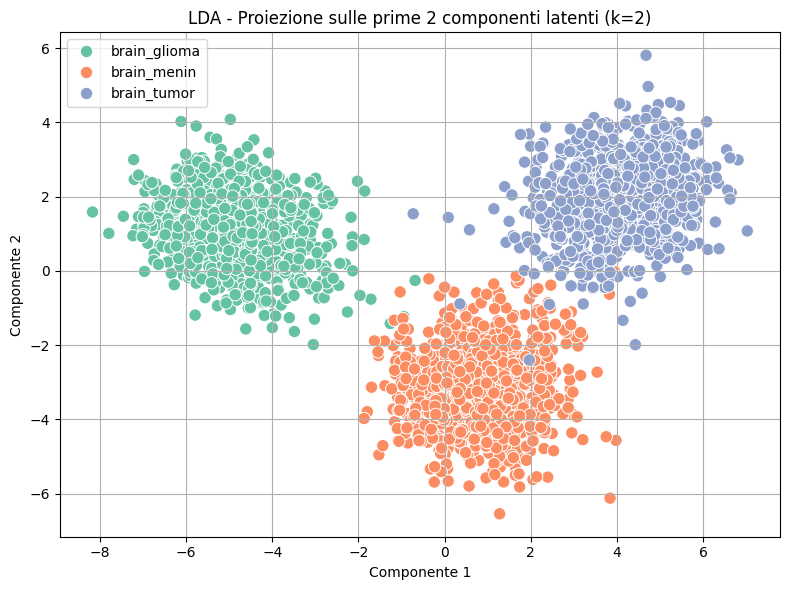

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnetfc_k2.txt


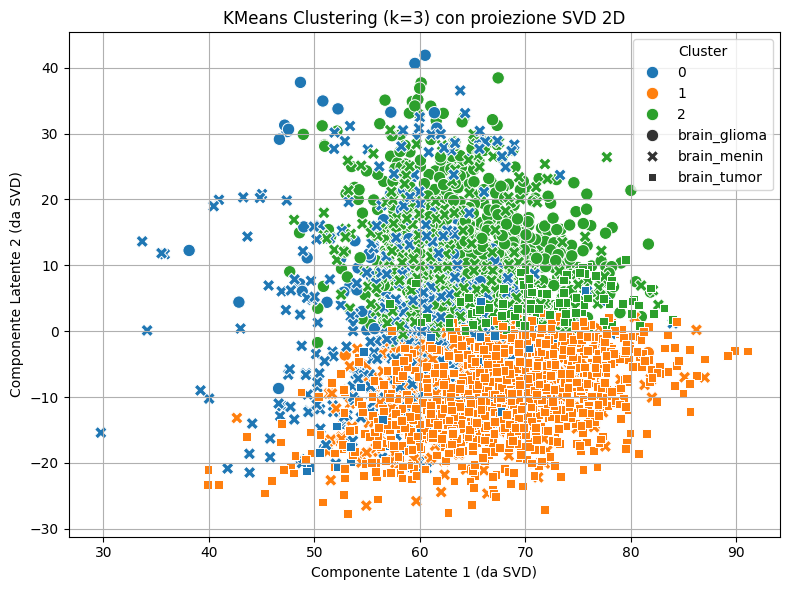

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnetfc_k3.txt


In [19]:
task5_latent_semantics_resnetfc("resnetfc.npz", technique="svd", k=5)
task5_latent_semantics_resnetfc("resnetfc.npz", technique="lda", k=2)
task5_latent_semantics_resnetfc("resnetfc.npz", technique="kmeans", k=3)